## Trabalho - Modelagem da água

In [1]:
using JuMP
using HiGHS
using PyPlot

## Modelagem

In [2]:
"""
Objetivo: otimizar a distribuição de água entre n consumidores e n reservatórios considerando t períodos de tempo, minimizando o custo

#### Input:
    demanda - matriz nx(t+1) em m^3 com a demanda do consumidor i no período j (sendo demanda[:, 1] = 0),
    custo - matriz nx(t+1) custo monetário de manter a bomba entre os poços e seus reservatórios i ligada durante todo o período j (sendo custo[:, 1] = 0), 
    vazao - valor em m^3 da vazão entre o poço e o reservatório,
    vazao_w - valor em m^3 da vazão das bombas entre os reservatórios,
    h_max - vetor n em m^3 com a capacidade máxima do reservatório i,
    h_min - vetor n em m^3 com a capacidade mínima do reservatório i,
    custo_γ - valor do custo monetário de transferência de água entre reservatórios,
    volume_inicial - vetor n em m^3 com o volume de água nos reservatórios no instante inicial. 

#### Output:
    x - matriz nx(t+1) com a fração do período j em que a bomba do poço i deve ficar ligada,
    z - matriz nXnX(t+1) com a fração do período j em que a bomba i deve transferir água para bomba k,
    f - valor da funçao minimizada.
"""
dagua(demanda :: Matrix{Float64},
    custo :: Matrix{Float64},
    vazao :: Float64,
    vazao_w :: Float64,
    h_max :: Vector{Float64},
    h_min :: Vector{Float64},
    custo_γ :: Float64,
    volume_inicial :: Vector{Float64})=
begin
    n, t_1 = size(demanda)
    
    modelo = Model.(HiGHS.Optimizer)
    @variable(modelo, volume[i = 1 : n, j = 1 : t_1] >= 0)
    @variable(modelo, 0 <= x[i = 1 : n, j = 1 : t_1] <= 1)
    @variable(modelo, 0 <= z[i = 1 : n, k = 1 : n, j = 1 : t_1] <= 1)

    @objective(modelo, Min, sum(custo[j, t] * x[j, t] for t in 2 : t_1 for j in 1 : n) + sum(custo_γ * z[j, l, t] for t in 2 : t_1 for j in 1 : n for l in 1 : n))

    @constraint(modelo, r1[i = 1 : n], sum(z[i, i, t] for t in 1 : t_1) == 0)
    @constraint(modelo, r2[j = 1 : n, t = 1 : (t_1)], h_min[j] <= volume[j, t] <= h_max[j])
    @constraint(modelo, r3[i = 1 : n], volume[i, 1] == volume_inicial[i])
    @constraint(modelo, r4, sum(x[i, 1] for i in 1 : n) == 0)
    @constraint(modelo, r5[j = 1 : n, t = 2 : t_1], volume[j, t] == volume[j, t - 1] + vazao * x[j, t] + sum(vazao_w * z[l, j, t] for l in 1 : n) - sum(vazao_w * z[j, l, t] for l in 1 : n) - (demanda[j, t]))

    optimize!(modelo)
    
    return value.(x), value.(z), objective_value(modelo), value.(volume)
end

dagua

In [3]:
?dagua

search: dagua



Objetivo: otimizar a distribuição de água entre n consumidores e n reservatórios considerando t períodos de tempo, minimizando o custo

#### Input:

```
demanda - matriz nx(t+1) em m^3 com a demanda do consumidor i no período j (sendo demanda[:, 1] = 0),
custo - matriz nx(t+1) custo monetário de manter a bomba entre os poços e seus reservatórios i ligada durante todo o período j (sendo custo[:, 1] = 0), 
vazao - valor em m^3 da vazão entre o poço e o reservatório,
vazao_w - valor em m^3 da vazão das bombas entre os reservatórios,
h_max - vetor n em m^3 com a capacidade máxima do reservatório i,
h_min - vetor n em m^3 com a capacidade mínima do reservatório i,
custo_γ - valor do custo monetário de transferência de água entre reservatórios,
volume_inicial - vetor n em m^3 com o volume de água nos reservatórios no instante inicial.
```

#### Output:

```
x - matriz nx(t+1) com a fração do período j em que a bomba do poço i deve ficar ligada,
z - matriz nXnX(t+1) com a fração do período j em que a bomba i deve transferir água para bomba k,
f - valor da funçao minimizada.
```


## Testes

 ### Teste 1 
 Foram usados valores retirados do artigo de referência com um horizonte de planejamento de 24 horas e três reservatórios.

In [4]:
demanda = [0.0 10 10 10 10 10 10 10 100 125 121 200 172 167 193 218 214 239 265 260 208 155 73 20 20;
           0.0 20 20 20 20 20 20 20 110 105 131 210 152 177 203 198 224 249 245 265 208 145 93 10 15;
           0.0 30 30 30 30 30 30 30 90 115 141 190 162 187 183 208 234 229 255 270 198 135 83 30 5]
custo = [0.0 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 60 60 60 30 30 30 30;
         0.0 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 60 60 60 30 30 30 30;
         0.0 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 60 60 60 30 30 30 30]
vazao = 300.0
vazao_w = 300.0
h_max = [2000.0, 1000, 1000]
h_min = [270.0, 270, 270]
custo_γ = 1.0
volume_inicial = [270.0, 270, 270]

t = zeros(25)
for i = 0 : 24
    t[i + 1] = i
end

x, z, f, volume = dagua(demanda,
    custo,
    vazao,
    vazao_w,
    h_max,
    h_min,
    custo_γ,
    volume_inicial)

return f

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
72 rows, 288 cols, 501 nonzeros
72 rows, 288 cols, 501 nonzeros
Presolve : Reductions: rows 72(-82); columns 288(-87); elements 501(-159)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     3.3327220453e-03 Pr: 72(8625) 0s
        144     8.6250000000e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 144
Objective value     :  8.6250000000e+02
HiGHS run time      :          0.00


862.5

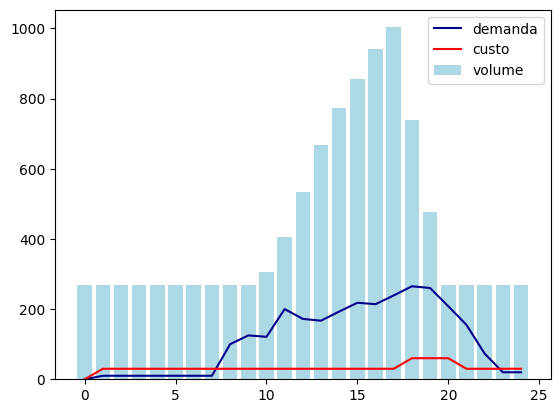

In [5]:
PyPlot.bar(t, volume[1, :], color="lightblue", label="volume")

PyPlot.plot(t, demanda[1, :], color="darkblue", label="demanda")
PyPlot.plot(t, custo[1, :], "r-", label="custo")

PyPlot.legend(loc="upper right",fancybox="true")

#savefig("res1")

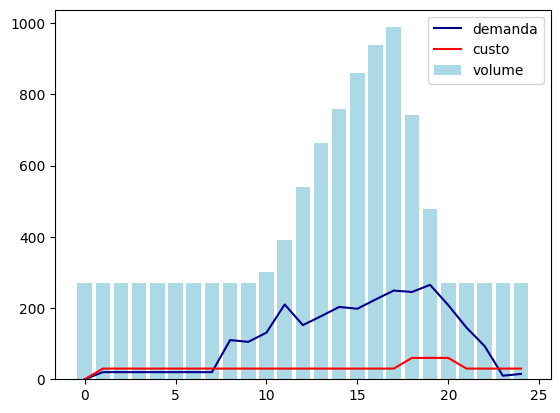

In [6]:
PyPlot.bar(t, volume[2, :], color="lightblue", label="volume")

PyPlot.plot(t, demanda[2, :], color="darkblue", label="demanda")
PyPlot.plot(t, custo[2, :], "r-", label="custo")

PyPlot.legend(loc="upper right",fancybox="true")
#savefig("res2")

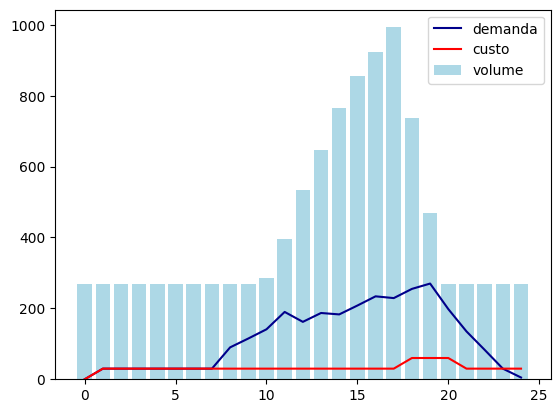

In [7]:
PyPlot.bar(t, volume[3, :], color="lightblue", label="volume")

PyPlot.plot(t, demanda[3, :], color="darkblue", label="demanda")
PyPlot.plot(t, custo[3, :], "r-", label="custo")

PyPlot.legend(loc="upper right",fancybox="true")
#savefig("res3")

 ### Teste 2
  Com os dados anteriores, foi elevado o custo do primeiro reservatório para forçar a transferência de água entre reservatórios.

In [8]:
demanda = [0.0 10 10 10 10 10 10 10 100 125 121 200 172 167 193 218 214 239 265 260 208 155 73 20 20;
           0.0 20 20 20 20 20 20 20 110 105 131 210 152 177 203 198 224 249 245 265 208 145 93 10 15;
           0.0 30 30 30 30 30 30 30 90 115 141 190 162 187 183 208 234 229 255 270 198 135 83 30 5]
custo = [0.0 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 90 90 90 50 50 50 50;
         0.0 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 60 60 60 30 30 30 30;
         0.0 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 60 60 60 30 30 30 30]
vazao = 300.0
vazao_w = 300.0
h_max = [2000.0, 1000, 1000]
h_min = [270.0, 270, 270]
custo_γ = 1.0
volume_inicial = [270.0, 270, 270]

t = zeros(25)
for i = 0 : 24
    t[i + 1] = i
end

x, z, f, volume = dagua(demanda,
    custo,
    vazao,
    vazao_w,
    h_max,
    h_min,
    custo_γ,
    volume_inicial)

return f

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
72 rows, 288 cols, 501 nonzeros
72 rows, 288 cols, 501 nonzeros
Presolve : Reductions: rows 72(-82); columns 288(-87); elements 501(-159)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     4.9990830289e-03 Pr: 72(8625) 0s
        151     8.7190000000e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 151
Objective value     :  8.7190000000e+02
HiGHS run time      :          0.00


871.9

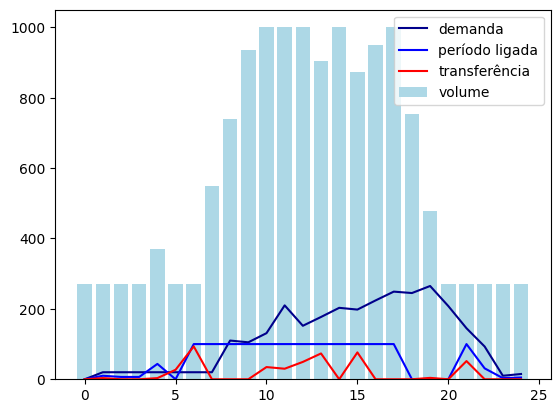

In [9]:
PyPlot.bar(t, volume[2, :], color="lightblue", label="volume")

PyPlot.plot(t, demanda[2, :], color="darkblue", label="demanda")

PyPlot.plot(t, 100 * x[2, :], "b-", label="período ligada")

PyPlot.plot(t, 100 * z[2, 1, :], "r-", label="transferência")

PyPlot.legend(loc="upper right",fancybox="true")

#savefig("t2-res2")

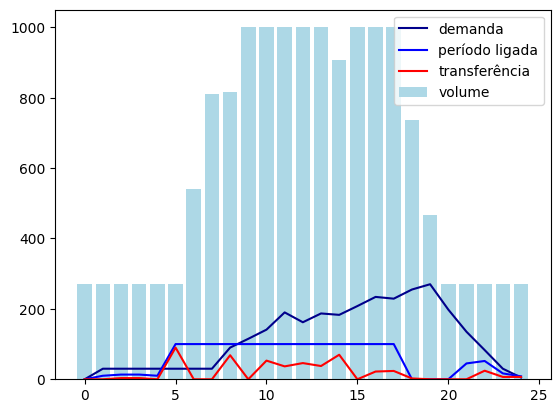

In [10]:
PyPlot.bar(t, volume[3, :], color="lightblue", label="volume")

PyPlot.plot(t, demanda[3, :], color="darkblue", label="demanda")

PyPlot.plot(t, 100 * x[3, :], "b-", label="período ligada")

PyPlot.plot(t, 100 * z[3, 1, :], "r-", label="transferência")

PyPlot.legend(loc="upper right",fancybox="true")

#savefig("t2-res3")

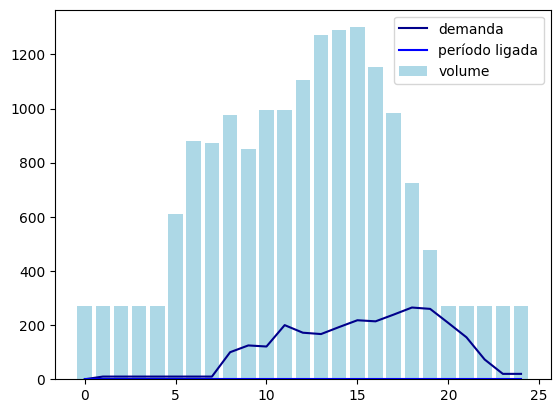

In [11]:
PyPlot.bar(t, volume[1, :], color="lightblue", label="volume")

PyPlot.plot(t, demanda[1, :], color="darkblue", label="demanda")

PyPlot.plot(t, 100 * x[1, :], "b-", label="período ligada")

PyPlot.legend(loc="upper right",fancybox="true")

#savefig("t2-res1")

 ### Teste 3
 Foi diminuido ainda mais o custo de ligar a bomba nos primeiros peíodos do dia. 

In [12]:
demanda = [0.0 10 10 10 10 10 10 10 100 125 121 200 172 167 193 218 214 239 265 260 208 155 73 20 20;
           0.0 20 20 20 20 20 20 20 110 105 131 210 152 177 203 198 224 249 245 265 208 145 93 10 15;
           0.0 30 30 30 30 30 30 30 90 115 141 190 162 187 183 208 234 229 255 270 198 135 83 30 5]
custo = [0.0 10 10 10 10 10 10 10 30 30 30 30 30 30 30 30 30 30 60 60 60 30 30 30 30;
         0.0 10 10 10 10 10 10 10 30 30 30 30 30 30 30 30 30 30 60 60 60 30 30 30 30;
         0.0 10 10 10 10 10 10 10 30 30 30 30 30 30 30 30 30 30 60 60 60 30 30 30 30]
vazao = 300.0
vazao_w = 300.0
h_max = [2000.0, 1000, 1000]
h_min = [270.0, 270, 270]
custo_γ = 1.0
volume_inicial = [270.0, 270, 270]

t = zeros(25)
for i = 0 : 24
    t[i + 1] = i
end

x, z, f, volume = dagua(demanda,
    custo,
    vazao,
    vazao_w,
    h_max,
    h_min,
    custo_γ,
    volume_inicial)

return f

Running HiGHS 1.4.2 [date: 1970-01-01, git hash: f797c1ab6]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
72 rows, 288 cols, 501 nonzeros
72 rows, 288 cols, 501 nonzeros
Presolve : Reductions: rows 72(-82); columns 288(-87); elements 501(-159)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     3.3327220453e-03 Pr: 72(8625) 0s
        146     6.2183333333e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 146
Objective value     :  6.2183333333e+02
HiGHS run time      :          0.00


621.8333333333334

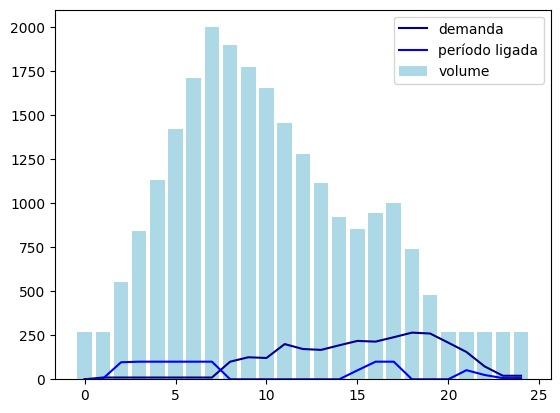

In [13]:
PyPlot.bar(t, volume[1, :], color="lightblue", label="volume")

PyPlot.plot(t, demanda[1, :], color="darkblue", label="demanda")

PyPlot.plot(t, 100 * x[1, :], "b-", label="período ligada")

PyPlot.legend(loc="upper right",fancybox="true")

#savefig("t3-res1")

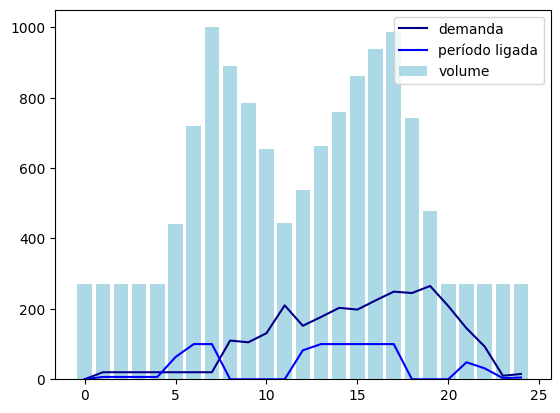

In [14]:
PyPlot.bar(t, volume[2, :], color="lightblue", label="volume")

PyPlot.plot(t, demanda[2, :], color="darkblue", label="demanda")

PyPlot.plot(t, 100 * x[2, :], "b-", label="período ligada")

PyPlot.legend(loc="upper right",fancybox="true")

#savefig("t3-res2")

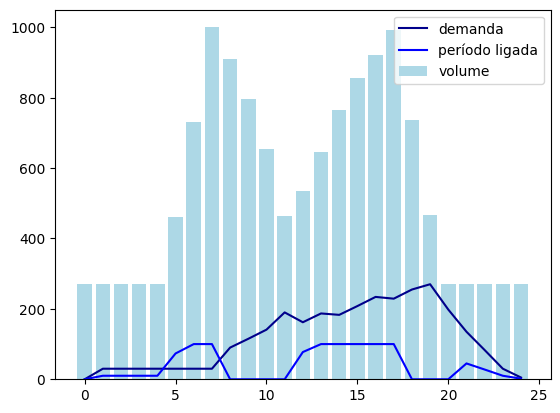

In [15]:
PyPlot.bar(t, volume[3, :], color="lightblue", label="volume")

PyPlot.plot(t, demanda[3, :], color="darkblue", label="demanda")

PyPlot.plot(t, 100 * x[3, :], "b-", label="período ligada")

PyPlot.legend(loc="upper right",fancybox="true")

#savefig("t3-res3")